In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from datetime import datetime
from scipy.stats import linregress, chisquare
from sklearn.linear_model import LinearRegression

# The Data Incubator Challenge

### Section 1
The New York City Fire Department keeps a log of detailed information on incidents handled by FDNY units. In this challenge we will work with a dataset that contains a record of incidents handled by FDNY units from 2013-2017.

In [2]:
fire_df = pd.read_csv('Incidents_Responded_to_by_Fire_Companies.csv', 
                      encoding='utf-8', 
                      engine='python')

In [3]:
fire_df.head()

,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG
0,55672688,2147,"300 - Rescue, EMS incident, other",01/01/2013 12:00:20 AM,01/01/2013 12:14:23 AM,1.0,01/01/2013 12:20:06 AM,"1 - More than initial alarm, less than Signal 7-5",1186.0,"00 - Action taken, other",...,10454,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55672692,0818,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:00:37 AM,01/01/2013 12:09:03 AM,3.0,01/01/2013 12:30:06 AM,"1 - More than initial alarm, less than Signal 7-5",1769.0,86 - Investigate,...,10036,1 - Manhattan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55672693,9656,"300 - Rescue, EMS incident, other",01/01/2013 12:01:17 AM,01/01/2013 12:04:55 AM,1.0,01/01/2013 12:15:18 AM,"1 - More than initial alarm, less than Signal 7-5",841.0,"00 - Action taken, other",...,11418,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55672695,7412,412 - Gas leak (natural gas or LPG),01/01/2013 12:02:32 AM,01/01/2013 12:07:48 AM,4.0,01/01/2013 12:40:11 AM,"1 - More than initial alarm, less than Signal 7-5",2259.0,44 - Hazardous materials leak control & contai...,...,11103,5 - Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55672697,4019,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:01:49 AM,01/01/2013 12:06:27 AM,6.0,01/01/2013 12:24:56 AM,"1 - More than initial alarm, less than Signal 7-5",1387.0,86 - Investigate,...,11385,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. What proportion of FDNY responses in this dataset correspond to the most common type of incident?

In [4]:
inc_count = fire_df.groupby(['INCIDENT_TYPE_DESC']).INCIDENT_TYPE_DESC.count()

proportion = inc_count.max() / inc_count.sum()
print('The proportion of most common incident is ', proportion)

The proportion of most common incident is  0.3614828304238471


2. What is the ratio of the average number of units that arrive to a scene of an incident classified as '111 - Building fire' to the number that arrive for '651 - Smoke scare, odor of smoke'?

In [5]:
# Building Fire Incident
building_fire = fire_df[fire_df['INCIDENT_TYPE_DESC'] == '111 - Building fire']
building_fire.UNITS_ONSCENE.mean()

# Smoke Incident
smoke = fire_df[fire_df['INCIDENT_TYPE_DESC'] == '651 - Smoke scare, odor of smoke']

avg = building_fire.UNITS_ONSCENE.mean() / smoke.UNITS_ONSCENE.mean()

print("The ratio is: ", avg)

The ratio is:  2.7597595139775324


3. How many times more likely is an incident in Staten Island a false call compared to in Manhattan? The answer should be the ratio of Staten Island false call rate to Manhattan false call rate. A false call is an incident for which 'INCIDENT_TYPE_DESC' is '710 - Malicious, mischievous false call, other'.

In [6]:
# See the Categories in 'BOROUGH_DESC'
fire_df.BOROUGH_DESC.unique()

array(['2 - Bronx', '1 - Manhattan', '5 - Queens', '4 - Brooklyn',
       '3 - Staten Island'], dtype=object)

In [7]:
# '1 - Manhattan'
manhattan = fire_df[fire_df.BOROUGH_DESC == '1 - Manhattan']
manhattan_ratio = (sum(manhattan.INCIDENT_TYPE_DESC 
                       == '710 - Malicious, mischievous false call, other') 
                   / manhattan.INCIDENT_TYPE_DESC.count())

# '3 - Staten Island'
staten_island = fire_df[fire_df.BOROUGH_DESC == '3 - Staten Island']
staten_island_ratio = (sum(staten_island.INCIDENT_TYPE_DESC 
                       == '710 - Malicious, mischievous false call, other') 
                   / staten_island.INCIDENT_TYPE_DESC.count())

inc_ratio = staten_island_ratio / manhattan_ratio

print("The ratio is: ", inc_ratio)

The ratio is:  1.6243819471953407


4. Check the distribution of the number of minutes it takes between the time a '111 - Building fire' incident has been logged into the Computer Aided Dispatch system and the time at which the first unit arrives on scene. What is the third quartile of that distribution. Note: the number of minutes can be fractional (ie, do not round).

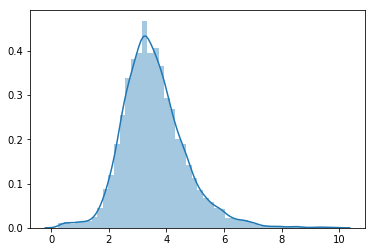

In [8]:
# Building Fire
building_fire = (fire_df[fire_df['INCIDENT_TYPE_DESC'] == '111 - Building fire'].dropna(
    subset=['INCIDENT_DATE_TIME', 'ARRIVAL_DATE_TIME']))

# Time Difference for Building Fire
time_diff = (building_fire.ARRIVAL_DATE_TIME.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')) -
             building_fire.INCIDENT_DATE_TIME.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')))
time_diff = time_diff.apply(lambda x: x.seconds // 60 + x.seconds % 60 / 60)

plt.figure()
sns.distplot(time_diff[time_diff < 10])
plt.show()

In [9]:
time_diff.describe()

count    13069.000000
mean         3.701988
std         12.607607
min          0.250000
25%          2.850000
50%          3.450000
75%          4.150000
max       1434.916667
dtype: float64

5. We can use the FDNY dataset to investigate at what time of the day people cook most. Compute what proportion of all incidents are cooking fires for every hour of the day by normalizing the number of cooking fires in a given hour by the total number of incidents that occured in that hour. Find the hour of the day that has the highest proportion of cooking fires and submit that proportion of cooking fires. A cooking fire is an incident for which 'INCIDENT_TYPE_DESC' is '113 - Cooking fire, confined to container'. Note: round incident times down. For example, if an incident occured at 22:55 it occured in hour 22.

In [10]:
all_inc = (fire_df['INCIDENT_DATE_TIME'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').hour)).value_counts()
cooking_fire = (fire_df[fire_df.INCIDENT_TYPE_DESC == '113 - Cooking fire, confined to container']
                ['INCIDENT_DATE_TIME'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p').hour)).value_counts()

hour_ratio = cooking_fire / all_inc

In [11]:
hour_ratio[hour_ratio == hour_ratio.max()].index

print("The hour of the day that has the highest proportion of cooking fires: ", 
     hour_ratio[hour_ratio == hour_ratio.max()].index[0])

The hour of the day that has the highest proportion of cooking fires:  18


6. What is the coefficient of determination (R squared) between the number of residents at each zip code and the number of inicidents whose type is classified as '111 - Building fire' at each of those zip codes.

In [12]:
# read zipcode dataframe
census = pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv')

In [13]:
census.head()

,Zip Code ZCTA,2010 Census Population
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [14]:
building_fire.ZIP_CODE = building_fire.ZIP_CODE.astype(int)
inc_count = pd.DataFrame(building_fire.groupby('ZIP_CODE').INCIDENT_TYPE_DESC.count()).reset_index()

incident_data = inc_count.merge(census, 
                left_on='ZIP_CODE',
                right_on='Zip Code ZCTA',
                how='inner')

slope, intercept, r_value, p_value, std_err = linregress(incident_data.INCIDENT_TYPE_DESC, 
                                                         incident_data['2010 Census Population'])

print('The R-squared value is:', r_value**2)

The R-squared value is: 0.597259561000609


7. For this question, only consider incidents that have information about whether a CO detector was present or not. We are interested in how many times more likely it is that an incident is long when no CO detector is present compared to when a CO detector is present. For events with CO detector and for those without one, compute the proportion of incidents that lasted 20-30, 30-40, 40-50, 50-60, and 60-70 minutes (both interval boundary values included) by dividing the number of incidents in each time interval with the total number of incidents. For each bin, compute the ratio of the 'CO detector absent' frequency to the 'CO detector present' frequency. Perform a linear regression of this ratio to the mid-point of the bins. From this, what is the predicted ratio for events lasting 39 minutes?

In [15]:
yes_co, no_co = (fire_df[fire_df.CO_DETECTOR_PRESENT_DESC == "Yes"], 
                 fire_df[fire_df.CO_DETECTOR_PRESENT_DESC == "No"])

In [16]:
def binned_minutes(df):
    bins = [20, 30, 40, 50, 60, 70]
    return (pd.cut(df['TOTAL_INCIDENT_DURATION'] / 60, bins=bins).value_counts()
            / df['TOTAL_INCIDENT_DURATION'].count())

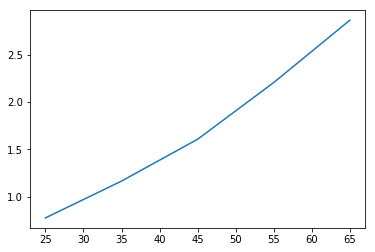

In [17]:
yes_co = binned_minutes(yes_co)
no_co = binned_minutes(no_co)
freq = no_co / yes_co
mid = np.array([25, 35, 45, 55, 65])

plt.figure()
plt.plot(mid, freq)
plt.show()

In [18]:
lr = LinearRegression()
lr.fit(mid.reshape(-1, 1), freq.values.reshape(-1, 1))
prediction = lr.predict(np.array([39]).reshape(1, -1))

print('Predicted Ratio for 39 min:', prediction[0][0])

Predicted Ratio for 39 min: 1.4088371233130825


8. Calculate the chi-square test statistic for testing whether an incident is more likely to last longer than 60 minutes when CO detector is not present. Again only consider incidents that have information about whether a CO detector was present or not.

In [19]:
chisquare(freq)

Power_divergenceResult(statistic=1.601600141194666, pvalue=0.8085045107806998)

### Section 2
A circular road has N positions labeled 0 through N−1 where adjacent positions are connected to each other and position N−1 is connected to 0. M cars start at position 0 through M−1 (inclusive). A car can make a valid move by moving forward one position (or goes from N-1 to 0) if the position it is moving into is empty. At each turn, only consider cars that have a valid move available and make one of the valid moves that you choose randomly with equal probability. After T rounds, we compute the average (A) and standard deviation (S) of the position of the cars.

In [20]:
from random import choice

In [21]:
class Road:
    # Initialize N number of positions and M cars on the roads
    def __init__(self, N, M):
        self.pos_num = N
        self.car_num = M
        self.pos = [False] * N
        self.pos[:M] = [True] * M
        
    def move_forward(self, i):
        if (i == (self.pos_num - 1)):
            self.pos[i], self.pos[0] = False, True
        else:
            self.pos[i], self.pos[i+1] = False, True
    
    # Move T rounds
    def move(self, T):
        for i in range(T):
            for j in range(self.pos_num):
                if (j == self.pos_num - 1):
                    if ((self.pos[0] == False) and choice([True, False])):
                        self.move_forward(j)
                else:
                    if((self.pos[j+1] == False) and choice([True, False])):
                        self.move_forward(j)
    
    # Calculate avg position and std of the positions of the cars
    def avg_pos_std(self):
        arr = []
        for i in range(self.pos_num):
            if(self.pos[i]):
                arr.append(i)
        
        arr = np.array(arr)
        return arr.mean(), arr.std()

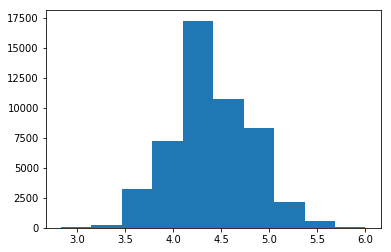

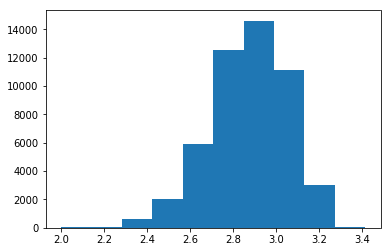

In [22]:
pos = []
std = []
N, M, T = 10, 5, 20

for i in range(50000):
    temp = Road(N, M)
    temp.move(T)
    pos_temp, std_temp = temp.avg_pos_std()
    pos.append(pos_temp)
    std.append(std_temp)

pos = np.array(pos)
std = np.array(std)

plt.figure()
plt.hist(pos)
plt.show()

plt.figure()
plt.hist(std)
plt.show()

In [23]:
print('The expected value and std of A when N = 10, M = 5, T = 20:',
      pos.mean(),
      pos.std())

print('The expected value and std of S when N = 10, M = 5, T = 20:',
      std.mean(),
      std.std())

The expected value and std of A when N = 10, M = 5, T = 20: 4.383829087301588 0.4092532958121936
The expected value and std of S when N = 10, M = 5, T = 20: 2.86742103165771 0.18924680389210222


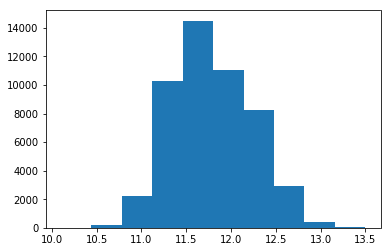

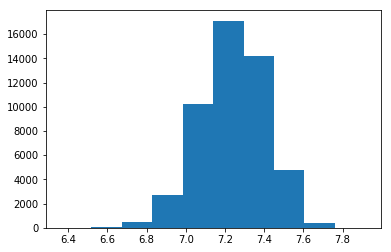

In [24]:
pos = []
std = []
N, M, T = 25, 10, 50

for i in range(50000):
    temp = Road(N, M)
    temp.move(T)
    pos_temp, std_temp = temp.avg_pos_std()
    pos.append(pos_temp)
    std.append(std_temp)

pos = np.array(pos)
std = np.array(std)

plt.figure()
plt.hist(pos)
plt.show()

plt.figure()
plt.hist(std)
plt.show()

In [25]:
print('The expected value and std of A when N = 25, M = 10, T = 50:',
      pos.mean(),
      pos.std())

print('The expected value and std of S when N = 25, M = 10, T = 50:',
      std.mean(),
      std.std())

The expected value and std of A when N = 25, M = 10, T = 50: 11.788708428723321 0.44596250533769455
The expected value and std of S when N = 25, M = 10, T = 50: 7.2410618575205685 0.16775084607944876


### Section 3
Propose a project to do while at The Data Incubator. We want to know about your ability to think at a high level. Try to think of projects that users or businesses will care about that are also relatively unanalyzed.

Propose a project that uses a large, publicly accessible dataset. Explain your motivation for tackling this problem, discuss the data source(s) you are using, and explain the analysis you are performing. 

### Project Ideas

Each year, many foreign workers are employed by American companies that are trying to fill positions that require special knowledge or education. These companies need to apply H1-B to those foreign workers which give workers authorization to work in the US. It is often a tedious and troublesome process. Therefore, I am proposing to have a Machine Learning model to predict the likelihood that if a person will be accepted to the H1-B program prior applying. It also gives suggestions to companies that should be changed in the applications to order to increase the chances of getting H1-B visa. Since the cost time and money for each denied H1-B case, the machine learning model aims to help business to save time and focus on more important tasks to worry.

From the first graph, it shows that most H1-B decisions are irrelevent to its salaries. I am a bit surprised by this result because I assumed that a higher paying job would usually mean a more specialized job that would requires a better approval chance.

The second graph shows that the average length of decisions. For the most part, it takes somewhere from 4 to 8 days to approve H1-B applications with median of 6 days to hear back. However, your case is denied, it will reply within with 10 days. 

https://www.kaggle.com/trivedicharmi/h1b-disclosure-dataset/home

In [26]:
h1b_data = pd.read_csv('1. Master H1B Dataset.csv',
                       encoding = "ISO-8859-1")

C:\Users\Siu Ka\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
h1b_data.head()

,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIEDWITHDRAWN
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,WITHDRAWN
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIEDWITHDRAWN


In [28]:
h1b_data.nunique()

CASE_SUBMITTED_DAY          31
CASE_SUBMITTED_MONTH        12
CASE_SUBMITTED_YEAR          7
DECISION_DAY                31
DECISION_MONTH               9
DECISION_YEAR                2
VISA_CLASS                   4
EMPLOYER_NAME            61103
EMPLOYER_STATE              56
EMPLOYER_COUNTRY             4
SOC_NAME                    56
NAICS_CODE                2030
TOTAL_WORKERS               52
FULL_TIME_POSITION           2
PREVAILING_WAGE          21955
PW_UNIT_OF_PAY               5
PW_SOURCE                    5
PW_SOURCE_YEAR              19
PW_SOURCE_OTHER            236
WAGE_RATE_OF_PAY_FROM    45729
WAGE_RATE_OF_PAY_TO      13038
WAGE_UNIT_OF_PAY             5
H-1B_DEPENDENT               2
WILLFUL_VIOLATOR             2
WORKSITE_STATE              55
WORKSITE_POSTAL_CODE     17894
CASE_STATUS                  4
dtype: int64

In [29]:
h1b_data.CASE_STATUS.unique()

array(['CERTIFIEDWITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED'],
      dtype=object)

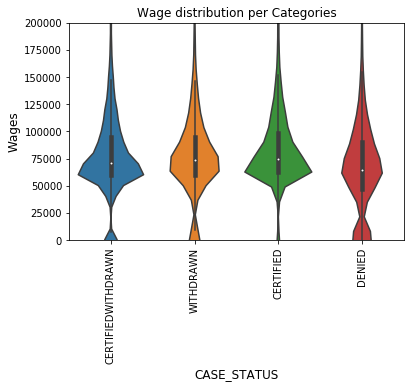

In [30]:
plt.figure()
sns.violinplot(x="CASE_STATUS", 
               y=h1b_data.WAGE_RATE_OF_PAY_FROM, 
               data=h1b_data)
plt.xticks(rotation='vertical')
plt.xlabel('CASE_STATUS', fontsize=12)
plt.ylabel('Wages', fontsize=12)
plt.title("Wage distribution per Categories")
plt.ylim((0, 200000))
plt.show()

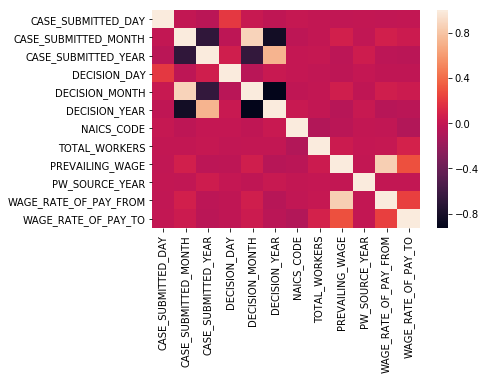

In [31]:
sns.heatmap(h1b_data.corr())

In [61]:
h1b_data['submitted_date'] = pd.to_datetime((
    h1b_data.CASE_SUBMITTED_YEAR*10000+
    h1b_data.CASE_SUBMITTED_MONTH*100+
    h1b_data.CASE_SUBMITTED_DAY).apply(str),
    format='%Y%m%d')

h1b_data['decision_date'] = pd.to_datetime((
    h1b_data.DECISION_YEAR*10000+
    h1b_data.DECISION_MONTH*100+
    h1b_data.DECISION_DAY).apply(str),
    format='%Y%m%d')

h1b_data['time_diff'] = (h1b_data['decision_date'] - 
                         h1b_data['submitted_date']).dt.days

In [58]:
# Only looking at Denied and Certified categories
selected = h1b_data[h1b_data.CASE_STATUS.apply(lambda x: 
                                    x in ['CERTIFIED', 'DENIED'])]

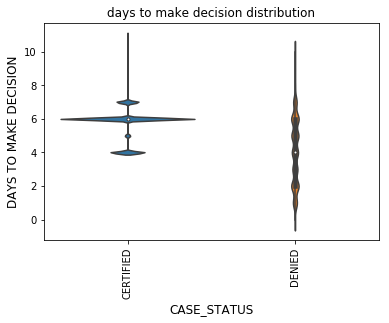

In [62]:
plt.figure()
sns.violinplot(x="CASE_STATUS", 
               y=selected.time_diff, 
               data=selected)
plt.xticks(rotation='vertical')
plt.xlabel('CASE_STATUS', fontsize=12)
plt.ylabel('DAYS TO MAKE DECISION', fontsize=12)
plt.title("days to make decision distribution")
plt.show()